In [1]:
import itertools
import numpy as np
import pandas as pd

from scipy import stats
# from statsmodels.stats.descriptivestats import sign_test

import matplotlib.pyplot as plt

In [37]:
def permutation_t_stat_2s(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_permutations):
    index = np.array(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_permutations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_null_dist_2s(sample1, sample2, max_permutations = None):
    pooled_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n2 = len(sample2)
    n = n1 + n2
    
    if max_permutations:
        indices = get_random_combinations(n1, n2, max_permutations)
    else:
        indices = [(list(index), filter(lambda x: x not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [permutation_t_stat_2s(pooled_sample[list(i[0])], pooled_sample[list(i[1])]) \
             for i in indices]
    return distr

def permutation_test_2s(sample1, sample2, max_permutations = None, alternative = 'two-sided', return_distr = False):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_2s(sample1, sample2)
    
    null_distr = permutation_null_dist_2s(sample1, sample2, max_permutations)
    
    if alternative == 'two-sided':
        p = sum([1. if abs(x) >= abs(t_stat) else 0. for x in null_distr]) / len(null_distr)
    elif alternative == 'less':
        p = sum([1. if x <= t_stat else 0. for x in null_distr]) / len(null_distr)
    else: # alternative == 'greater':
        p = sum([1. if x >= t_stat else 0. for x in null_distr]) / len(null_distr)
    
    if return_distr:
        return {'t': t_stat, 'p': p, 'null_distr': null_distr}
    else:
        return {'t': t_stat, 'p': p}

In [4]:
data = pd.read_csv('verizon.txt', sep='\t')
data.head()

,Time,Group
0,17.50,ILEC
1,2.40,ILEC
2,0.00,ILEC
3,0.65,ILEC
4,22.23,ILEC


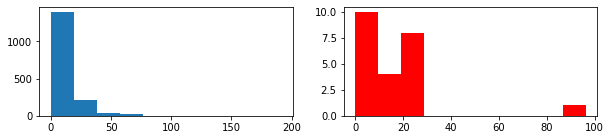

In [14]:
plt.figure(figsize=(10, 2))

plt.subplot(1, 2, 1)
plt.hist(data[data['Group'] == 'ILEC']['Time'])

plt.subplot(1, 2, 2)
plt.hist(data[data['Group'] == 'CLEC']['Time'], color='r')

plt.show()

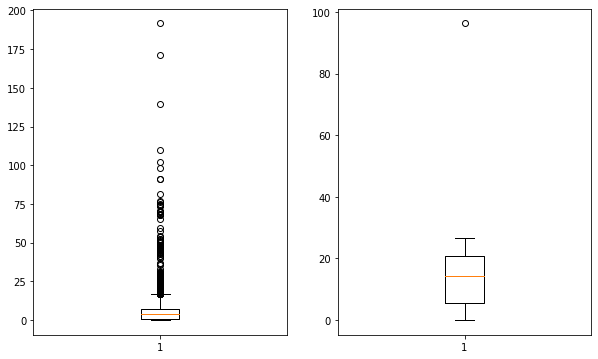

In [16]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.boxplot(data[data['Group'] == 'ILEC']['Time'])

plt.subplot(1, 2, 2)
plt.boxplot(data[data['Group'] == 'CLEC']['Time'])

plt.show()

In [18]:
print('Diff in means: ', round(data[data['Group'] == 'ILEC'].Time.mean() - data[data['Group'] == 'CLEC'].Time.mean(), 1))

Diff in means:  -8.1


#### Sign test

In [22]:
print('Sign test p-value:')
1 - stats.binom.cdf(
    k=data[(data['Group'] == 'CLEC') & (data['Time'] > 8.)].shape[0] - 1,
    n=len(data[data['Group'] == 'CLEC']['Time']),
    p=0.5)

Sign test p-value:


0.10501980781555176

In [23]:
round(0.10501980781555176, 4)

0.105

####  t-test hypothesis of equal means

In [26]:
print('t-test: ')
stats.ttest_ind(data[data['Group'] == 'CLEC']['Time'], 
                data[data['Group'] == 'ILEC']['Time'], 
                equal_var = False,
               alternative='greater')

t-test: 


Ttest_indResult(statistic=1.9833785404229538, pvalue=0.02987306070737932)

In [28]:
round(0.02987306070737932, 4)

0.0299

#### Rank test

In [35]:
print("Mann-Whitney test:")
stats.mannwhitneyu(data[data['Group'] == 'CLEC']['Time'], 
                   data[data['Group'] == 'ILEC']['Time'],
                  alternative='greater')

Mann-Whitney test:


MannwhitneyuResult(statistic=26820.0, pvalue=0.00045651384433380884)

In [36]:
round(0.00045651384433380884, 5)

0.00046

#### Permutation test

In [39]:
np.random.seed(0)
res = permutation_test_2s(data[data['Group'] == 'CLEC']['Time'], 
                          data[data['Group'] == 'ILEC']['Time'], 
                          max_permutations=10000,
                          alternative='greater',
                          return_distr = True)
print("Permutation test: t = %f, p = %f" % (res['t'], res['p']))

Permutation test: t = 8.097520, p = 0.017900
